## Install (Colab only)
Skip this step when running locally.

In [1]:
# !pip install ...

# Import libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import pickle
import time

# Keras
import keras
from keras import Sequential, Input
from keras.models import Model
from keras.layers import GRU, Embedding, Dense, TimeDistributed, Bidirectional, LSTM, Dropout

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# filter some user warnings from torch broadcast
import warnings
warnings.filterwarnings("ignore")

In [3]:
# TF / Keras random number generator
tf.random.set_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Loading data

In [4]:
#!/bin/bash
!mkdir -p ./data

!curl -L -o ./data/archive.zip \
https://www.kaggle.com/api/v1/datasets/download/alfrandom/protein-secondary-structure

!unzip ./data/archive.zip -d ./data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 38.8M  100 38.8M    0     0  46.3M      0 --:--:-- --:--:-- --:--:-- 46.3M
Archive:  ./data/archive.zip
  inflating: ./data/2018-06-06-pdb-intersect-pisces.csv  
  inflating: ./data/2018-06-06-ss.cleaned.csv  


In [5]:
df = pd.read_csv('./data/2018-06-06-ss.cleaned.csv')
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


# Preprocessing

<Axes: >

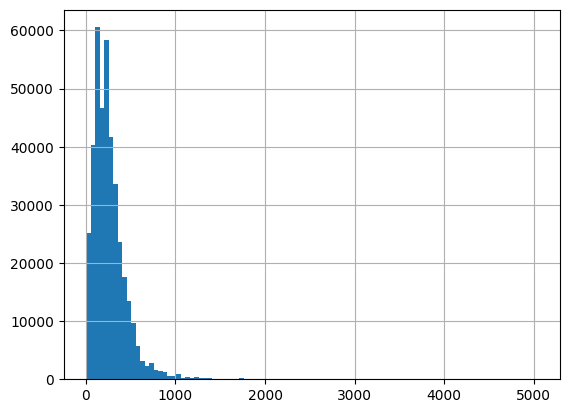

In [6]:
df.len.hist(bins=100)

In [7]:
MIN_AMINO_ACID_LEN = 100
MAX_AMINO_ACID_LEN = 300

print(f"No. of sequences with non-standard amino acids: {len(df[df['has_nonstd_aa'] == True])}")
print(f"No. of sequences with length < {MIN_AMINO_ACID_LEN} or > {MAX_AMINO_ACID_LEN}: {len(df[(df['len'] < MIN_AMINO_ACID_LEN) | (df['len'] > MAX_AMINO_ACID_LEN)])}")
print(f"Fraction of data removed: {(len(df[df['has_nonstd_aa'] == True]) + len(df[(df['len'] < MIN_AMINO_ACID_LEN) | (df['len'] > MAX_AMINO_ACID_LEN)])) / len(df):.2f}")

df = df[df['has_nonstd_aa'] == False]
df = df[(df['len'] >= MIN_AMINO_ACID_LEN) & (df['len'] <= MAX_AMINO_ACID_LEN)]

print(f"\nDataframe shape after preprocessing: {len(df)}")

No. of sequences with non-standard amino acids: 7399
No. of sequences with length < 100 or > 300: 184686
Fraction of data removed: 0.49

Dataframe shape after preprocessing: 207571


# Train, validation, test set split

In [8]:
_train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(_train, test_size=0.2)

print(f'Train size: {len(train)}')
print(f'Validation size: {len(val)}')
print(f'Test size: {len(test)}')

Train size: 132844
Validation size: 33212
Test size: 41515


# Encoding / Decoding

In [9]:
def seq2kmers(seqs, n = 3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs], dtype="object")

In [10]:
INPUT_COL = 'seq'
TARGET_COL = 'sst3'

# Generate k-mers from sequences
train_kmers = seq2kmers(train[INPUT_COL].to_list())
val_kmers = seq2kmers(val[INPUT_COL].to_list())
test_kmers = seq2kmers(test[INPUT_COL].to_list())

print(f'Train kmers shape: {train_kmers.shape}')
print(f'Validation kmers shape: {val_kmers.shape}')
print(f'Test kmers shape: {test_kmers.shape}')

Train kmers shape: (132844,)
Validation kmers shape: (33212,)
Test kmers shape: (41515,)


In [11]:
# Defining tokenizers
encoder = Tokenizer()
decoder = Tokenizer(char_level=True)

# Defining corpus
all_kmers = np.concatenate([train_kmers, val_kmers, test_kmers])
encoder.fit_on_texts(train_kmers)

decoder.fit_on_texts(train[TARGET_COL].to_list())

print(f'Vocabulary size: {len(encoder.word_index) + 1}')
print(f'Target vocabulary size: {len(decoder.word_index) + 1}')

Vocabulary size: 8420
Target vocabulary size: 4


In [12]:
def encode(X, y):
    X = encoder.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=MAX_AMINO_ACID_LEN, padding='post')

    y = decoder.texts_to_sequences(y)
    y = pad_sequences(y, maxlen=MAX_AMINO_ACID_LEN, padding='post')
    y = to_categorical(y)

    return X, y

def decode(y):
    y = np.argmax(y, axis=-1)
    y = decoder.sequences_to_texts(y)
    return y

In [13]:
X_train, y_train = encode(train_kmers, train[TARGET_COL].to_list())
X_val, y_val = encode(val_kmers, val[TARGET_COL].to_list())

print(f"Training shapes X: {X_train.shape}, y: {y_train.shape}")
print(f"Validation shapes X: {X_val.shape}, y: {y_val.shape}")

Training shapes X: (132844, 300), y: (132844, 300, 4)
Validation shapes X: (33212, 300), y: (33212, 300, 4)


# Model creation

In [14]:
n_words = len(encoder.word_index) + 1
n_ssts = len(decoder.word_index) + 1

model = Sequential()
model.add(Input(shape=(MAX_AMINO_ACID_LEN,)))
model.add(Embedding(n_words, 128, input_length=MAX_AMINO_ACID_LEN))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_ssts, activation='softmax')))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 300, 128)            │       1,077,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300, 256)            │         198,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 300, 256)            │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 300, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 300, 4)              │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,573,380 (6.00 MB)

 Trainable params: 1,573,380 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
@keras.saving.register_keras_serializable()
def q3_acc(y_true, y_pred):
    # Get the true and predicted class indices
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)

    # Create a mask to exclude any unwanted classes (e.g., padding with index 0)
    mask = y > 0

    # Calculate accuracy on masked values
    correct_predictions = tf.boolean_mask(y, mask) == tf.boolean_mask(y_, mask)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

    return accuracy


class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', q3_acc])

In [17]:
BATCH_SIZE = 64
EPOCHS = 10

time_callback = TimeHistory()
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[time_callback])

Epoch 1/10
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 298s 133ms/step - accuracy: 0.8202 - loss: 0.4199 - q3_acc: 0.7239 - val_accuracy: 0.8868 - val_loss: 0.2781 - val_q3_acc: 0.8248
Epoch 2/10
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 274s 132ms/step - accuracy: 0.8928 - loss: 0.2648 - q3_acc: 0.8343 - val_accuracy: 0.9077 - val_loss: 0.2302 - val_q3_acc: 0.8571
Epoch 3/10
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 275s 132ms/step - accuracy: 0.9111 - loss: 0.2224 - q3_acc: 0.8625 - val_accuracy: 0.9181 - val_loss: 0.2071 - val_q3_acc: 0.8732
Epoch 4/10
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 273s 131ms/step - accuracy: 0.9220 - loss: 0.1970 - q3_acc: 0.8794 - val_accuracy: 0.9247 - val_loss: 0.1926 - val_q3_acc: 0.8834
Epoch 5/10
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 275s 132ms/step - accuracy: 0.9291 - loss: 0.1803 - q3_acc: 0.8903 - val_accuracy: 0.9299 - val_loss: 0.1811 - val_q3_acc: 0.8914
Epoch 6/10
2076/2076 ━━━━━━━━━━━━━━━━━━━━ 274s 132ms/step - accuracy: 0.9346 - loss: 0.1675 - q3_acc: 0.8988 - val_accuracy: 0.9334 - val_lo

# Export model

In [18]:
PREFIX = 'BI-GRU'

# Save model
model.save(f'{PREFIX}.model.keras')

# Save history
with open(f'{PREFIX}.history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

with open(f'{PREFIX}.history_times.pkl', 'wb') as f:
    pickle.dump(time_callback.times, f)

# Test set performance

In [19]:
X_test, y_test = encode(test_kmers, test[TARGET_COL].to_list())

print(f"Test shapes X: {X_test.shape}, y: {y_test.shape}")

Test shapes X: (41515, 300), y: (41515, 300, 4)


In [20]:
eval = model.evaluate(X_test, y_test)
print(f'Test loss: {eval[0]:.2f}')
print(f'Test accuracy: {eval[1]:.2f}')
print(f'Test Q3 accuracy: {eval[2]:.2f}')

1298/1298 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.9427 - loss: 0.1534 - q3_acc: 0.9114
Test loss: 0.15
Test accuracy: 0.94
Test Q3 accuracy: 0.91


In [21]:
# Visualise results
LABEL_WIDTH = 12
random_indexes = np.random.choice(len(test), 5)

for ind, i in enumerate(random_indexes):
    print(f"Example #{ind + 1}")

    y_pred = model.predict(X_test[i:i+1])

    pred, act = y_pred[0], y_test[i]
    dec_pred, dec_act = decode([pred])[0], decode([act])[0]
    dec_pred = dec_pred.replace(' ', '')
    dec_act = dec_act.replace(' ', '')

    diff = ''.join(['*' if dec_pred[i] != dec_act[i] else dec_act[i] for i in range(min(len(dec_pred), len(dec_act)))])

    print(f"{'Predicted:'.ljust(LABEL_WIDTH)} {dec_pred}")
    print(f"{'Actual:'.ljust(LABEL_WIDTH)} {dec_act}")
    print(f"{'Difference:'.ljust(LABEL_WIDTH)} {diff}")
    print()

Example #1
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted:   cchhhhhhhhhhhhhhcchhhhhhhhhhchhccccchhhhhhhhccccccchhhhhhhheeecccccccchhhcccccccccchhhhhhhhhhhhhhccccccccccccchhhhhhhhhhhhhcccchhhhhhhhhcccceeeeeeeeeeechhhhhhhhhhhhhhhhhhccchhhhhhhhhhhhhhhhhhhhhhhhhccccccchhhhhhhhhhhhhhhcccccccccccchhhhhhhhhhhhhhhhhhhhhhhhhhhhhcccccccc
Actual:      cchhhhhhhhhhhhcccchhhhhhhhhhcchhhccchhhhcchhhhccccchhhhhhhceeeccccccchhhhceccccceccchhhhhhhhhhhhcccccccccccccchhhhhhhhhhhhhhccchhheeehhhhhhccceeeecceeeehhhhhhchhhhhhhhhhcccchhhhhhhhhhhhhhcchhhhhhhhcccccccchhhhhhhhhhhhhhcccccccccceechhhhhhhhhhhhhhhhhhhhhhhhhhhhhhccccccc
Difference:  cchhhhhhhhhhhh**cchhhhhhhhhhc*h**ccchhhh**hh**ccccchhhhhhh*eeeccccccc*hhhc*ccccc*cc*hhhhhhhhhhhh*ccccccccccccchhhhhhhhhhhhh*ccchhh***hhh***c**eeee**eee*hhhhhh*hhhhhhhhhh*ccchhhhhhhhhhhhhh**hhhhhhhh*ccccccchhhhhhhhhhhhhh*ccccccccc**chhhhhhhhhhhhhhhhhhhhhhhhhhhhh*ccccccc

Example #2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted:   ccceeeeeeecccceeeeeeccccchhhhhhhhhhhhccch